# [NTDS'19] assignment 2: learning with graphs
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `<your team number>`
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

# Part I: Spectral Graph Theory
## Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

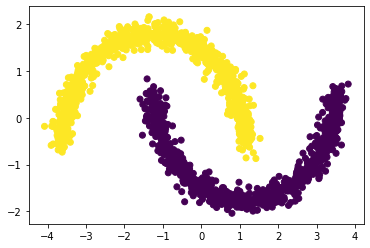

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-\gamma\; ||x_i- x_j||_2^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [4]:
def similarity_graph(X: np.ndarray, gamma=1e-6, threshold=0):
    """ X (n x d): coordinates of the n data points in R^d.
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    dist = squareform(pdist(X))
    adjacency = np.exp(- gamma * dist ** 2)
    adjacency[adjacency<threshold] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

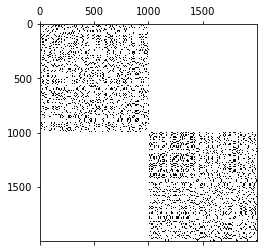

In [5]:
adjacency = similarity_graph(X, gamma=10, threshold=0.01)
plt.spy(adjacency)
plt.show()

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [6]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    combinatorial = D - adjacency
    if normalize:
        D_norm = np.diag(np.clip(np.sum(adjacency, 1),1,None)**(-1/2))
        return D_norm @ combinatorial @ D_norm
    else:
        return combinatorial
    return D - adjacency

In [7]:
laplacian_comb = compute_laplacian(adjacency, False)
laplacian_norm = compute_laplacian(adjacency, True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. Justify your choice of a solver for the eigendecomposition.


*Your answer here*

In [8]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        e (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    pass
    return np.linalg.eigh(laplacian)

In [9]:
e_comb, U_comb = spectral_decomposition(laplacian_comb)
e_norm, U_norm = spectral_decomposition(laplacian_norm)

#### Question 4: Interpretation
We plot the cumulative distribution of the eigenvalues:

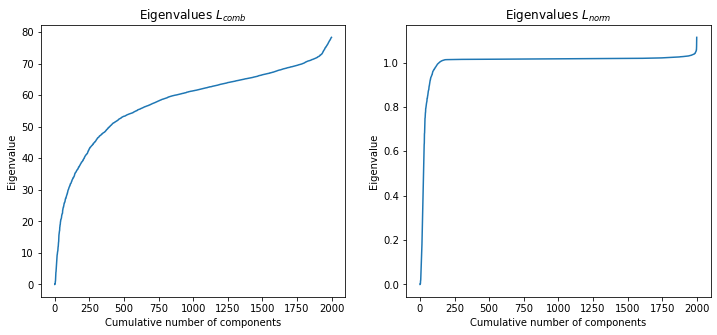

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121,)
plt.plot(e_comb)
plt.xlabel('Cumulative number of components')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(e_norm)
plt.xlabel('Cumulative number of components')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

*Your answer here*

When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

*Your answer here*

#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [11]:
def compute_number_connected_components(e: np.array, threshold: float):
    """ e: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return np.count_nonzero(e <= threshold)

In [12]:
print(compute_number_connected_components(e_norm, threshold=1e-12))

1


## Spectral clustering
Let us now see one application of spectral graph theory to clustering the two moon dataset.
#### Question 6: Baseline
As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

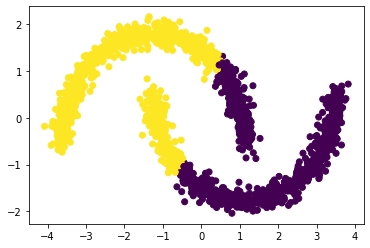

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

K-means cannot find a good solution to this problem. Why?

*Your answer here*

#### Question 7: Spectral clustering
As opposed to K-means, spectral clustering does not work directly on the input space of the data, but constructs a network representation of the data, and finds communities within the data.

Implement spectral clustering.

In [14]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.U = None
        self.clustering_method = KMeans(n_classes)
        
    def fit_predict(self, adjacency):
        """ Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency, self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        n_connected = compute_number_connected_components(self.e, threshold=1e-12)
        first_columns = self.U[:, n_connected: n_connected + self.n_classes] 
        y_pred = self.clustering_method.fit_predict(first_columns)
        return y_pred

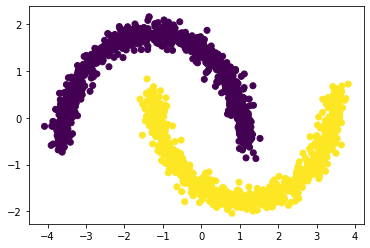

In [15]:
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

#### Question 8: On your dataset
Can you think of another 2D dataset in which k-means would perform bad, but spectral clustering not? Construct it! For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

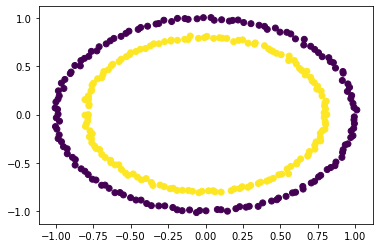

In [16]:
from sklearn.datasets import make_circles
X, y = make_circles(300, noise=0.01)
plt.scatter(X[:, 0], X[:,1], c=y)
plt.show()

Run K-means:

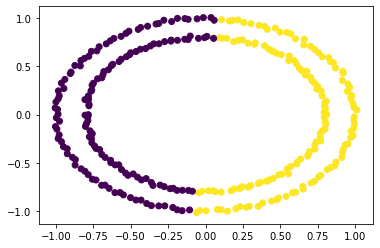

In [17]:
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

Create the similarity graph, and run spectral clustering:

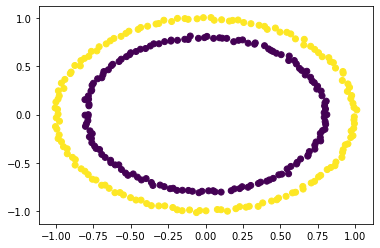

In [18]:
adjacency=similarity_graph(X, gamma=5e2, threshold=0)
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

## Dimensionality Reduction with Laplacian Eigenmaps
Most datasets are very high-dimensional, which means it can be very hard to understand the geometry that the data takes in such a high-dimensional space. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to learn about some of these techniques (Laplacian eigenmaps and PCA). Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset. You first need to install the python-mnist library from pip. Windows users may have to do it from a windows prompt. For unix users, run the following line:

In [19]:
! pip install python-mnist

Then, download mnist from http://yann.lecun.com/exdb/mnist/ and extract it in a data folder. We will process it using the following:

In [20]:
from utils import load_mnist

path_to_data = '../Developer/ntds_2019_private/assignments/data/mnist'
X_mnist, y_mnist = load_mnist(path_to_data)
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps
Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

*Your answer here*

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.

In [21]:
def laplacian_eigenmaps(X:np.ndarray, dim:int, gamma:float, threshold:float):
    adjacency = similarity_graph(X,gamma,threshold)
    laplacian = compute_laplacian(adjacency, True)
    e, U = spectral_decomposition(laplacian)
    return U[:,1:dim+1]

Use this function to visualize MNIST in 2d. Feel free to play with the different parameters.

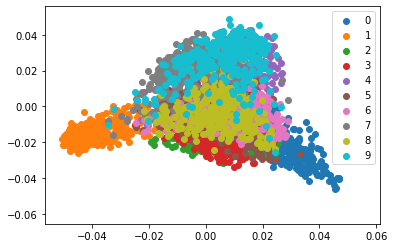

In [22]:
dim = 2
gamma = 4e-7
threshold = 0

X_2d = laplacian_eigenmaps(X_mnist, dim, gamma, threshold)
for i in classes:
    mask = y_mnist == i
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=i)
plt.legend()
plt.show()

Visualize MNIST in 3d:

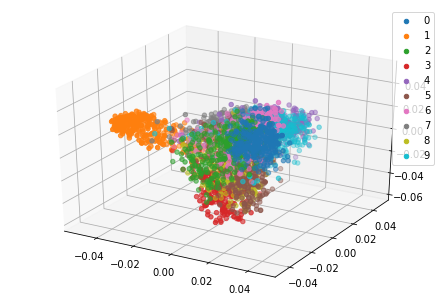

In [23]:
dim = 3
gamma = 4e-7
threshold = 0

X_3d = laplacian_eigenmaps(X_mnist, dim, gamma, threshold)

fig = plt.figure()
ax = Axes3D(fig)
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2], label=i)
plt.legend()
plt.show()

#### Question 10: Comparison with PCA
The most common method to do dimensionality reduction is Principal Component Analysis (PCA). Compared to Laplacian eigenmaps, what property does PCA preserve?

*Your answer here*

Using `sklearn.decomposition.PCA`, perform dimensionality reduction on MNIST and compare the results with the ones you obtained before.

In [24]:
from sklearn.decomposition import PCA

In 2d:

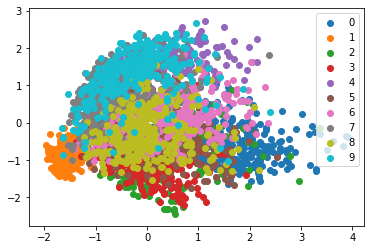

In [25]:
pca = PCA(n_components=2, copy=True, whiten=True, tol=1e-5)
X2 = pca.fit_transform(X_mnist)
for i in classes:
    mask = y_mnist == i
    plt.scatter(X2[mask, 0], X2[mask, 1], label=i)
plt.legend()
plt.show()

In 3d:

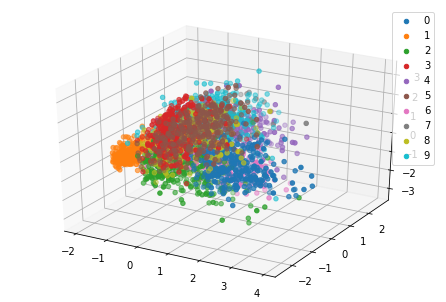

In [26]:
pca = PCA(n_components=3, copy=True, whiten=True, tol=1e-5)
X3 = pca.fit_transform(X_mnist)
fig = plt.figure()
ax = Axes3D(fig)
for i in classes:
    mask = y_mnist == i
    ax.scatter(X3[mask, 0], X3[mask, 1], X3[mask, 2], label=i)
plt.legend()
plt.show()

Based on this results, which method do you think says more about this data?

*Your answer here*

# Part II: Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [27]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [28]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [29]:
def plot_bunny(signal=None,title=''):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if signal is not None:
        signal = np.squeeze(signal)
    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=signal, marker='o', s=5, cmap='RdBu_r')
    ax.view_init(elev=-90,azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if signal is not None:
        fig.colorbar(p)

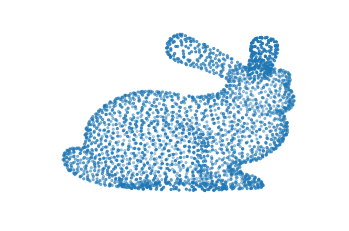

In [30]:
plt.subplot(111,projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition...

In [31]:
laplacian = compute_laplacian(adjacency, True)
e, U = spectral_decomposition(laplacian)

Plot the eigenvalues

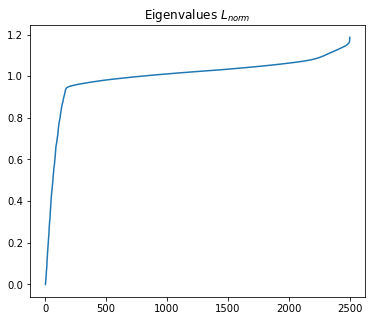

In [32]:
plt.figure(figsize=(6,5))
plt.plot(e)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

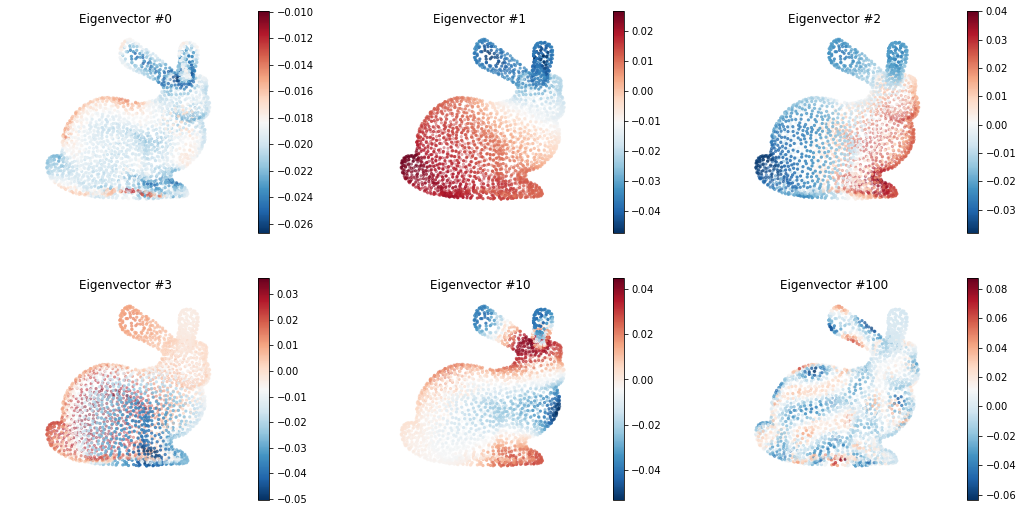

In [33]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(signal=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(signal=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(signal=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(signal=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(signal=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(signal=U[:,100], title='Eigenvector #100')

What can you say in terms of the variations/smoothness of these signals. How can the smoothness of a signal be measured?

*Your answer here*

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform and its inverse of a graph signal. **Note**: You can assume that you have internal access to the eigendecomposition (`U` and `e`) of the laplacian.

In [34]:
def GFT(signal: np.ndarray):
    return U.T @ signal

def iGFT(fourier_coefficients: np.ndarray):
    return U @ fourier_coefficients

Now, let's create an all-pass graph signal

/Users/gortizji/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


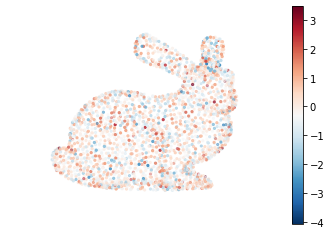

In [35]:
signal = iGFT(np.ones([n_nodes, 1]))
plot_bunny(signal)

and plot its graph spectrum

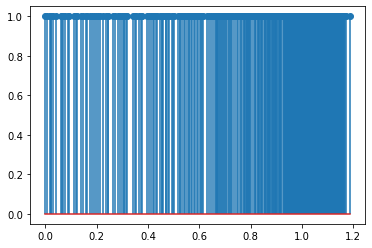

In [36]:
plt.stem(e, GFT(signal), use_line_collection=True)
plt.show()

#### Question 13: Graph filters
We will filter this signal using spectral templates. Let us start by creating three templates

In [37]:
template_lp = np.ones(signal.shape)
template_bp = np.ones(signal.shape)
template_hp = np.ones(signal.shape)

template_lp[e >= 0.1] = 0 # Low-pass filter with cut-off at lambda=0.1
template_bp[e < 0.1] = 0 # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
template_bp[e > 0.5] = 0
template_hp[e <= 1] = 0 # High-pass filter with cut-off at lambda=1

Create a function to filter a signal given a specific spectral template

In [38]:
def template_graph_filter(signal: np.ndarray, template: np.ndarray):
    """Return a filtered signal."""
    signal_gft = GFT(signal)
    filter_gft = signal_gft * template
    return iGFT(filter_gft)

Let us visualize the results

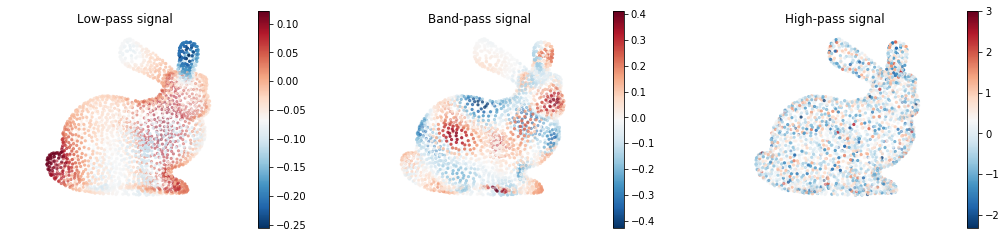

In [39]:
signal_lp = template_graph_filter(signal,template_lp)
signal_bp = template_graph_filter(signal,template_bp)
signal_hp = template_graph_filter(signal,template_hp)

plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(signal=signal_lp, title='Low-pass signal')
plt.subplot(132, projection='3d')
plot_bunny(signal=signal_bp, title='Band-pass signal')
plt.subplot(133, projection='3d')
plot_bunny(signal=signal_hp, title='High-pass signal')

What can you say in terms of the signal variations? How would you link to the observations you made before about the spectral decomposition of the laplacian?

*Your answer here*

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
\begin{equation}
        L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
        \lambda_0^k &\dots & 0\\
        \vdots & \ddots & \vdots\\
        0 & \dots & \lambda_N
        \end{bmatrix} U^T
    \end{equation}
$$

This means, that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right)$$


With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Let us create a band-pass universal spectral template:

In [40]:
freq_grid = np.linspace(0,2, 200)

template_bp = np.ones(freq_grid.shape)
template_bp[freq_grid < 0.1] = 0
template_bp[freq_grid >= 0.5] = 0

Implement a function to find the coefficients of a polynomial that approximates a given spectral template. **Hint:** `np.vander` and `np.linalg.lstsq`

In [41]:
def fit_polynomial(freq_grid: np.ndarray, order: int, template: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    A = np.vander(freq_grid, order, increasing=True)
    coeff = np.linalg.lstsq(A, template, rcond=None)[0]
    return coeff

Implement a function to compute the frequency response of that filter

In [42]:
def fir_graph_filter_response(coeff: np.array, freq_grid: np.ndarray):
    """ Return an array of the same shape as freq_grid.
        response[i] is the spectral response at frequency freq_grid[i]. """
    response = np.zeros_like(freq_grid)
    for n, c in enumerate(coeff):
        response += c * (freq_grid**n)
    return response

Let us fit the band-pass template with several polynomials of different order

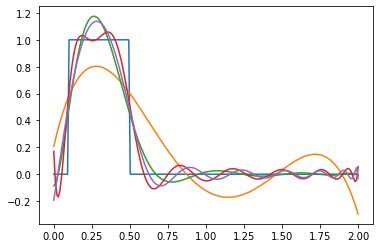

In [43]:
plt.plot(freq_grid, template_bp)
for order in [5, 10, 20, 30]:    
    coeff_bp = fit_polynomial(freq_grid, order, template_bp)
    plt.plot(freq_grid, fir_graph_filter_response(coeff_bp, freq_grid))

#### Question 14: Filter data
Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [44]:
order = 10
coeff_bp = fit_polynomial(freq_grid, order, template_bp)

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [45]:
def fir_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    power = np.eye(laplacian.shape[0])
    filt = coeff[0] * power
    for n, c in enumerate(coeff[1:]):
        power = laplacian @ power
        filt += c * power
    return filt

In [46]:
g_bp = fir_graph_filter(coeff_bp, laplacian)

Filter the previous all-pass signal with this filter

In [47]:
signal_bp_fir = g_bp @ signal

Let us compare with the previous version

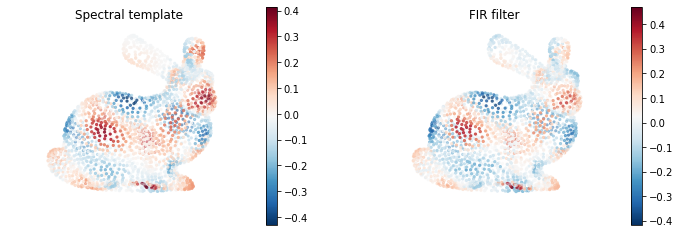

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(121, projection='3d')
plot_bunny(signal_bp, title='Spectral template')
plt.subplot(122, projection='3d')
plot_bunny(signal_bp_fir, title='FIR filter')

To better compare these signals, let us plot their spectrums

<StemContainer object of 3 artists>

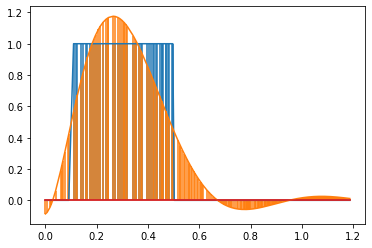

In [49]:
plt.stem(e, GFT(signal_bp), use_line_collection=True, linefmt='C0', markerfmt='C0')
plt.stem(e, GFT(signal_bp_fir), use_line_collection=True, linefmt='C1', markerfmt='C1')

# Part III: Machine learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [50]:
import networkx as nx

import time
import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora
from sklearn.linear_model import LogisticRegression

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library.

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph. Our task is to design a classifier that using these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs. We assume that we know to which scientific field belongs a small subset of the papers (the ones contained in train_mask). The goal is to predict to which field belong the other papers, using both the citation graph and the bag-of-word representation of each paper.

In [51]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))

For this exercise we will use the combinatorial laplacian

In [52]:
laplacian = compute_laplacian(adjacency, normalize=False)
U, e = spectral_decomposition(laplacian)
e_max = np.max(e)
freq_grid = np.linspace(0, e_max)

#### Question 15: Logistic regression
The simplest classification method consists in ignoring the citation graph and try to classify the papers using only the features. In this case, the problem is viewed as a standard classification task. To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them. To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set. And finally, we will test our classifier on the rest of the nodes. **Hint:** Use `sklearn.linear_model.LogisticRegression`.

In [53]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [54]:
log_reg = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg.fit(train_features, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
train_acc = log_reg.score(train_features, train_labels)
val_acc = log_reg.score(val_features, val_labels)
test_acc = log_reg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5967 | Test accuracy 0.6050


#### Question 15: Handcrafted graph filters
That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

*Your answer here*

Based on this prior design a graph spectral template that you believe could enhance important features of the graph. 

**Note 1:** You just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note 2:** Finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [56]:
filter_template = np.ones(freq_grid.shape)

filter_template[freq_grid >= 0.3] = 0 # Low-pass filter with cut-off at lambda=0.1

Choose a filter order to approximate your filter using laplacian polynomials.

In [57]:
order = 5

coeff = fit_polynomial(freq_grid, order, filter_template)
graph_filter = fir_graph_filter(coeff, laplacian)

Let's plot the frequency response of your spectral template and its polynomial approximation

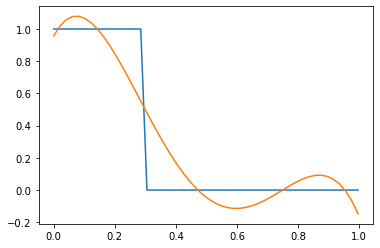

In [58]:
plt.plot(freq_grid, filter_template)
plt.plot(freq_grid, fir_graph_filter_response(coeff, freq_grid))

Now, let's create the new features

In [59]:
filtered_features = graph_filter @ features.numpy()

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [60]:
log_reg = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg.fit(train_features, train_labels)

/Users/gortizji/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Let's evaluate your model...

In [61]:
train_acc = log_reg.score(train_features, train_labels)
val_acc = log_reg.score(val_features, val_labels)
test_acc = log_reg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.9714 | Validation accuracy 0.4133 | Test accuracy 0.3100


#### Question 16: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as in Exercise 5, but now, instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful is you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [62]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)


    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k):
            graph.ndata['h'] = feat
            # Update_all computes efficiently A @ feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            # LX = DX - AX
            feat = graph.in_degrees().float()[:, None] * feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model

In [63]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()    # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


def evaluate(model, g, features, labels, mask):
    model.eval()   # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Let's choose the training parameters...

In [64]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

and train the classifier end to end

In [65]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/gortizji/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gortizji/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.9459 | Val Accuracy 0.1600
Epoch 00001 | Time(s) nan | Train Loss 3.8731 | Val Accuracy 0.1833
Epoch 00002 | Time(s) nan | Train Loss 2.0940 | Val Accuracy 0.1767
Epoch 00003 | Time(s) 0.0142 | Train Loss 2.8990 | Val Accuracy 0.1967
Epoch 00004 | Time(s) 0.0146 | Train Loss 3.8503 | Val Accuracy 0.1867
Epoch 00005 | Time(s) 0.0148 | Train Loss 2.1611 | Val Accuracy 0.2000
Epoch 00006 | Time(s) 0.0157 | Train Loss 2.5059 | Val Accuracy 0.2000
Epoch 00007 | Time(s) 0.0155 | Train Loss 3.3099 | Val Accuracy 0.1900
Epoch 00008 | Time(s) 0.0152 | Train Loss 3.2475 | Val Accuracy 0.3533
Epoch 00009 | Time(s) 0.0151 | Train Loss 1.9366 | Val Accuracy 0.1667
Epoch 00010 | Time(s) 0.0151 | Train Loss 2.9027 | Val Accuracy 0.1700
Epoch 00011 | Time(s) 0.0151 | Train Loss 2.9171 | Val Accuracy 0.1733
Epoch 00012 | Time(s) 0.0152 | Train Loss 2.1271 | Val Accuracy 0.2800
Epoch 00013 | Time(s) 0.0152 | Train Loss 1.9733 | Val Accuracy 0.2567
Epoch 00014 | T

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learnt...

In [66]:
coeff_gcn = model.pol_weights.detach().numpy()
print(coeff_gcn)

[ 1.7719086e+01 -4.4402270e+00  1.8523736e-01  9.2400319e-04]


To interpret the model we can plot the frequency response of the learned filter

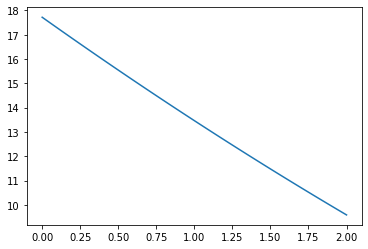

In [67]:
freq_grid_0to2 = np.linspace(0, 2, 50)
plt.plot(freq_grid_0to2, fir_graph_filter_response(coeff_gcn, freq_grid_0to2))
plt.show()

As you can see, this filter is low pass, but it does not cut a lot the high frequencies. Can you explain why a filter that keeps only low frequencies might not work well for classification?

*Your answer here*

#### Question 17
As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor

In [68]:
graph_gcn_filter = fir_graph_filter(coeff_gcn, laplacian)

Let's extract the new features by filtering the data

In [69]:
features_gcn = graph_gcn_filter @ features.numpy()

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on this features

In [70]:
log_reg_gcn = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg_gcn.fit(train_features_gcn, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Finally, let's evaluate this model

In [71]:
train_acc = log_reg_gcn.score(train_features_gcn, train_labels)
val_acc = log_reg_gcn.score(val_features_gcn, val_labels)
test_acc = log_reg_gcn.score(test_features_gcn, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.7533 | Test accuracy 0.7520


The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

*Your answer here*